In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Analysis_functions import *
import plotly.graph_objs as go
import statsmodels.api as sm

In [15]:
# Read the CSV file
raw = np.loadtxt('80deg.csv', delimiter=',', skiprows=1)

# Extract the relevant data
time = raw[:, 3]/1000
temp = np.delete(raw, [2, 3], axis=1)
# temp = np.delete(temp, np.s_[::2], axis=1)
"""
# Find the first index where the value reaches 90°C or more, and removes the data afterwards
argmax = np.argmax(temp >= 90, axis=0)
min_argmax = np.argmin(argmax)
temp = np.delete(temp, np.s_[argmax[min_argmax]+1:], axis=0)
time = np.delete(time, np.s_[argmax[min_argmax]+1:], axis=0)
ambient = np.delete(ambient, np.s_[argmax[min_argmax]+1:], axis=0)
"""
# Calculate the average of the data
temp = np.mean(temp, axis=1)

N = temp.shape[0]
ambient = np.full(N, temp[0])
"""
# Removes the data before the experiment starts
exp_start = 30 # seconds
exp_start_index = np.argmax(time >= exp_start)
temp = np.delete(temp, np.s_[:exp_start_index], axis=0)
time = np.delete(time, np.s_[:exp_start_index], axis=0)
ambient = np.delete(ambient, np.s_[:exp_start_index], axis=0)
"""
# Save the processed data to a new CSV file
# np.savetxt('/path/to/processed_data.csv', temp, delimiter=',')


'\n# Removes the data before the experiment starts\nexp_start = 30 # seconds\nexp_start_index = np.argmax(time >= exp_start)\ntemp = np.delete(temp, np.s_[:exp_start_index], axis=0)\ntime = np.delete(time, np.s_[:exp_start_index], axis=0)\nambient = np.delete(ambient, np.s_[:exp_start_index], axis=0)\n'

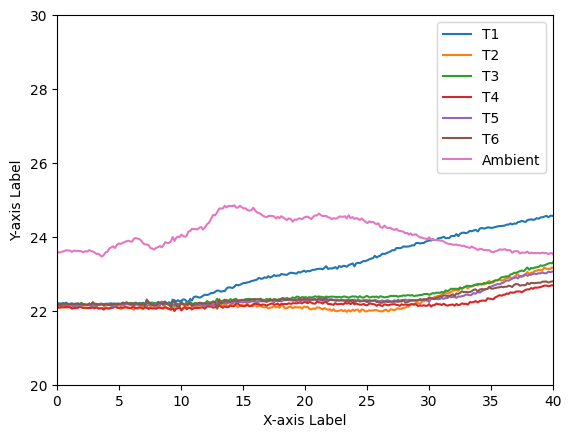

In [4]:
# Plot the data
plt.plot(raw[:, 0], raw[:, 1], label='T1')
plt.plot(raw[:, 0], raw[:, 3], label='T2')
plt.plot(raw[:, 0], raw[:, 5], label='T3')
plt.plot(raw[:, 0], raw[:, 7], label='T4')
plt.plot(raw[:, 0], raw[:, 11], label='T5')
plt.plot(raw[:, 0], raw[:, 13], label='T6')
plt.plot(raw[:, 0], raw[:, 9], label='Ambient')

# Add labels and legend
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()

plt.xlim(0, 40)  # Adjust the range as needed
plt.ylim(20, 30) 
plt.show()

In [22]:
window = 20
N = temp.shape[0]
print(f'Number of data points: {N}')
frac = window / N  # Equivalent to MATLAB window parameter
print(f'Fraction: {frac}')

# Apply the LOWESS smoothing to the experimental temperature data
smoothed_temp = sm.nonparametric.lowess(temp, time, frac=frac)
# Apply the LOWESS smoothing to the ambient temperature data
smoothed_ambient = sm.nonparametric.lowess(ambient, time, frac=frac)

Number of data points: 480
Fraction: 0.041666666666666664


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=temp, mode='lines', name='Temp'))
fig.add_trace(go.Scatter(x=smoothed_temp[:, 0], y=smoothed_temp[:, 1], mode='lines', name='Smoothed Temp'))
fig.add_trace(go.Scatter(x=time, y=ambient, mode='lines', name='Ambient'))
fig.add_trace(go.Scatter(x=smoothed_ambient[:, 0], y=smoothed_ambient[:, 1], mode='lines', name='Smoothed Ambient'))
fig.show()

In [24]:
mass_water = 105  # g
dT_threshold = 3

# Computes the power over the whole experiment
power_input = power(smoothed_temp[:, 0], smoothed_temp[:, 1], mass_water)
prw_vs_temp = np.array([(smoothed_temp[:, 1] - smoothed_ambient[:, 1])[1:], power_input])

# Sorts the data in increasing order of x values
sorted_indices = np.argsort(prw_vs_temp[0, :])
prw_vs_temp = prw_vs_temp[:, sorted_indices]

# Removes the data before the temperature difference reaches the threshold
#argmax_dT = np.argmax(prw_vs_temp[0, :] >= dT_threshold)
#prw_vs_temp = np.delete(prw_vs_temp, np.s_[:argmax_dT], axis=1)

In [25]:
# Performs a linear fit on the power vs temperature delta curve
prw_vs_temp_fit = sm.add_constant(prw_vs_temp)
X = np.column_stack((np.ones_like(prw_vs_temp_fit[0, :]), prw_vs_temp_fit[0, :]))
y = prw_vs_temp_fit[1, :]
model = sm.OLS(y, X)

results = model.fit()
# print(results.summary())
params = results.params
print(f'Slope of the fitted line: {params[1]} W/°C')

def linear_fit(x, params):
    return params[1]*x + params[0] 

fitted_line = linear_fit(prw_vs_temp[0, :], params)

Slope of the fitted line: -0.19502296486511236 W/°C


In [26]:
# Power vs temperature delta curve with the linear fit
fig = go.Figure()
fig.add_trace(go.Scatter(x=prw_vs_temp[0, :], y=prw_vs_temp[1, :], mode='lines', name='Data'))
fig.add_trace(go.Scatter(x=prw_vs_temp[0, :], y=fitted_line, mode='lines', name='fitted line'))
fig.show()

In [28]:
# Computes the total energy harvested during the experiment
energy = energy_stored(temp, mass_water)
print(f'Energy harvested: {energy} J')

Energy harvested: 23405.498500019392 J
